In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
import keras 
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model


modelPath = '/home/wz/HD1/wz/face/classification/inception_resnet_v2/inception_resnet_v2_check/checkpoint-78e-val_acc_0.671271.hdf5'
dataPath = '/home/wz/HD1/wz/face/新6类疾病patch1230/新6类疾病patch1230/val/'
confSavePath ='/home/wz/HD1/wz/face/confusionMatrix'
confTitle = 'Inception_resnet_v2'
batchSize = 32

classList = ['basal cell carcinoma', 
'lupus erythematosus',
'rosacea', 
'seborrheic keratosis', 
'solar keratosis',
'squamous carcinoma']

/home/wz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
valDataGen = ImageDataGenerator(rotation_range=0,
                              width_shift_range=0,
                              height_shift_range=0,
                              horizontal_flip=False,
                              vertical_flip=False,
                              fill_mode='nearest',
                              data_format='channels_last')

valGenerator = valDataGen.flow_from_directory(dataPath,
                                      target_size=(300,300), 
                                       color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=batchSize, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix=None,
                            save_format='jpeg',
                            follow_links=False)

Found 362 images belonging to 6 classes.


In [3]:
labelList = []
resultList = []

with tf.device('/gpu:0'):
    model = load_model(modelPath)
    
    for batch in range(len(valGenerator)):
        x, y = next(valGenerator)
        result = model.predict_on_batch(x)
        resultList.extend(list(result))
        labelList.extend(list(y))
    #result = model.evaluate_generator(valGenerator , steps=valNumber/batchSize, max_queue_size=64, workers=1, use_multiprocessing=False, verbose=1)
    #result = model.predict_generator(valGenerator, steps=valNumber/batchSize, max_queue_size=64, workers=1, use_multiprocessing=False, verbose=1)

In [4]:
classDict = valGenerator.class_indices
classDict2 = dict(zip(classDict.values(),classDict.keys()))
resultList = [list(i) for i in resultList]
labelList = [list(i) for i in labelList]

resultList= [i.index(max(i)) for i in resultList]
labelList = [i.index(max(i)) for i in labelList ]

In [6]:
import re
import numpy as np  
import matplotlib.pyplot as plt    
from sklearn.metrics import roc_curve, auc  ###计算roc和auc  

# LABELS为数字化标签与文字标签对应的dict，key为数字
# y_pred为模型输出,np.array类型，如64个样本，6类，则其 shape应为(64,1)，每个元素都是预测类别
# y_true为标签列表
LABELS = classDict2
y_pred = resultList
y_true = labelList

In [7]:
def plot_confusion_matrix(y_true, y_pred, labels, save_path, title):
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10), dpi=300)
    
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 # 标记在图片中对文字是整数型还是浮点型
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=20, va='center', ha='center')

        else:
            c = cm_normalized[y_val][x_val]
            if (c > 0.01):
                #这里是绘制数字，可以对数字大小和颜色进行修改
                plt.text(x_val, y_val, "%0.3f" % (c,), color='red', fontsize=20, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=20, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=45)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes', fontsize=20)
    plt.xlabel('Index of Predict Classes', fontsize=20)
    plt.title('confusion matrix to 6 classes of %s'%title, fontsize=20)
    plt.savefig(os.path.join(save_path, '{0}-confusionMatrix.jpg'.format(title)), dpi=300)
    plt.show()

/home/wz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


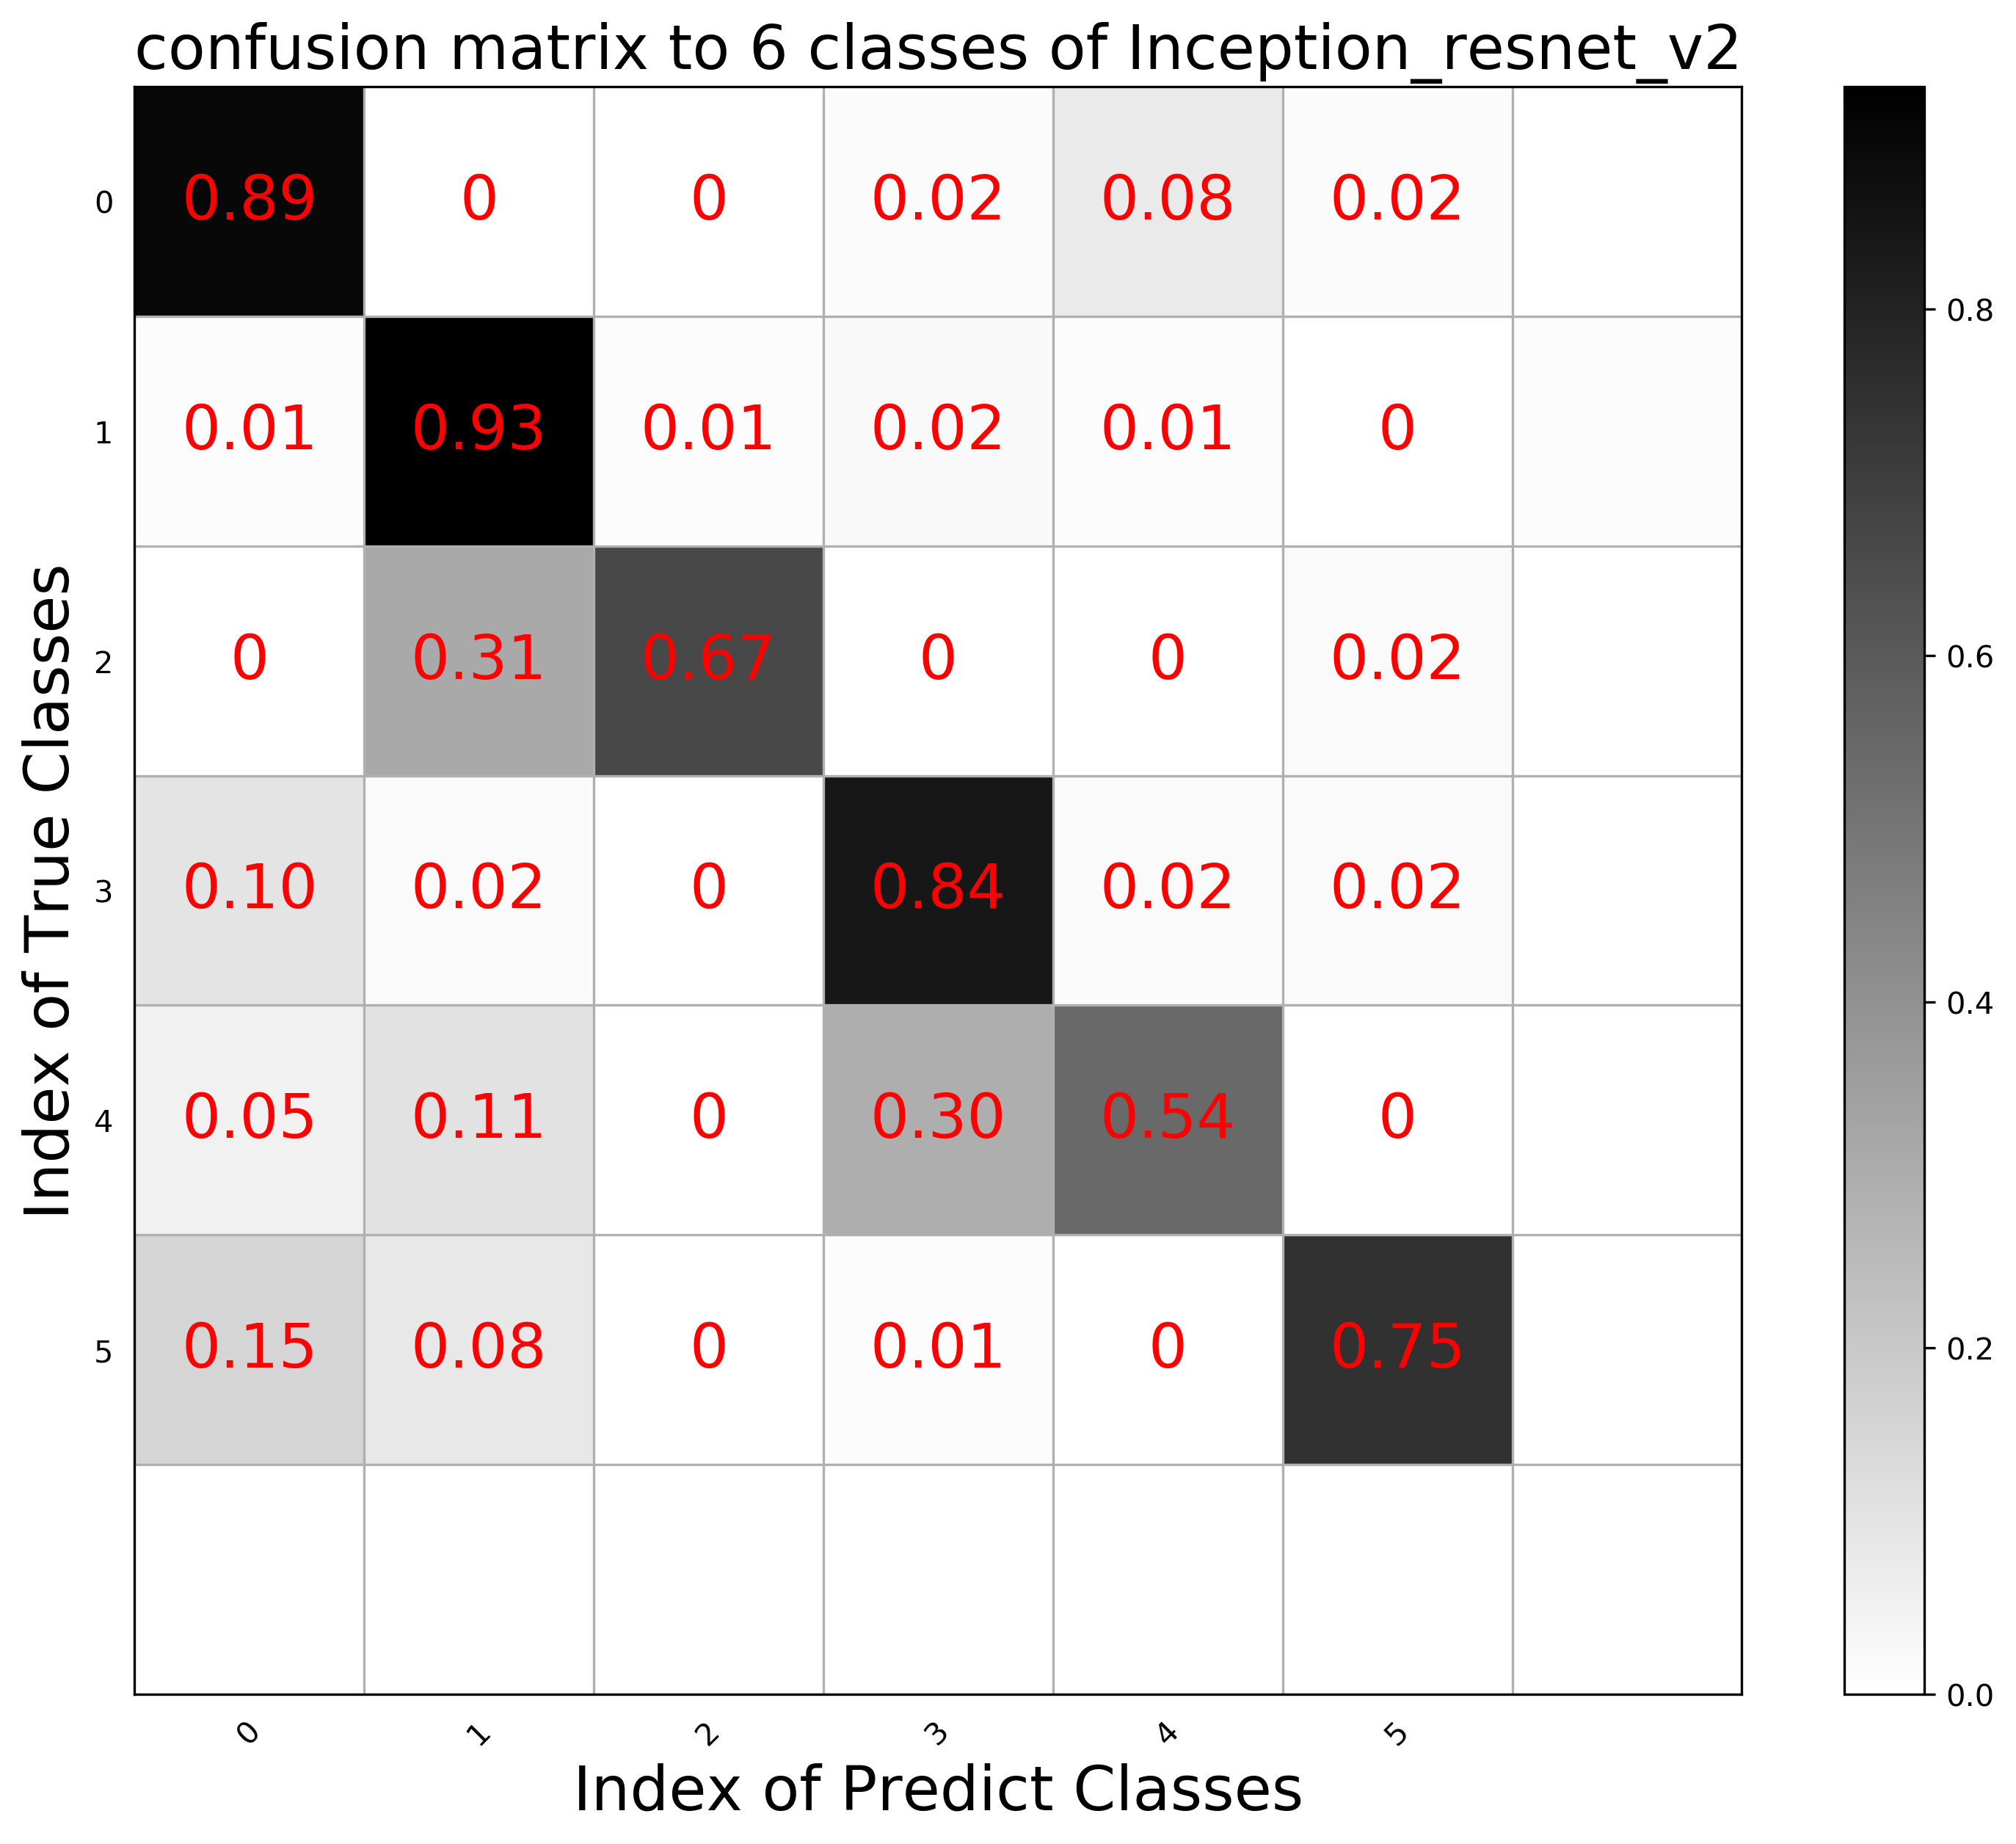

In [8]:
plot_confusion_matrix(y_true,y_pred,LABELS, confSavePath, confTitle)